##               Lecture 12                  
                                           
 Simple (Linear) Regressions             
   - multiple graphs and descriptive     
   - Scatterplots                        
       - to decide functional form       
       - to decide outcome variable      
   - Simple, nonlinear models:           
       - models with log                 
       - polynomials                     
       - piecewise linear spline         
       - extra: weighted OLS             
   - Residual analysis                   
       - with multiple annotations       
                                           
Case Study:                               
-  Life-expectancy and income               

___

Import packages

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

In [2]:
df = pd.read_csv("data/WDI_lifeexp_clean.csv")

df.head()

,country,population,gdppc,lifeexp
0,United Arab Emirates,9.770526,67.119153,77.972
1,Afghanistan,38.041757,2.065036,64.833
2,Antigua and Barbuda,0.097115,21.548725,77.016
3,Albania,2.854191,13.671488,78.573
4,Armenia,2.957728,13.653763,75.087


Good-to-know: Quick check on all HISTOGRAMS

array([[<AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'gdppc'}>],
       [<AxesSubplot:title={'center':'lifeexp'}>, <AxesSubplot:>]],
      dtype=object)

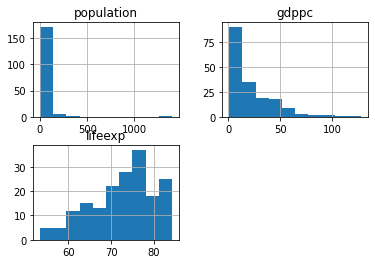

In [3]:
df.hist()

In [4]:
df.describe()

,population,gdppc,lifeexp
count,180.000000,180.000000,180.000000
mean,41.657096,21.438360,72.726386
std,150.361578,22.555867,7.377117
min,0.063913,0.751664,53.283000
25%,2.270922,5.122250,67.773250
50%,8.828019,13.367983,74.067000
75%,30.769718,31.004150,77.873500
max,1397.715000,127.903180,84.356341


Create new variable: Total GDP = GDP per Capita * Population


    note we could have download an other GDP total variable for this,
    but for comparison purposes, let use the exact same data and 
    concentrate on difference which are only due to transforming the variables.

In [5]:
df["gdptot"] = df["gdppc"] * df["population"]

### Check basic scatter-plots!

Two competing models:
- A) lifeexp = alpha + beta * gdptot
- B) lifeexp = alpha + beta * gdppc

Where to use log-transformation? - level-level vs level-log vs log-level vs log-log

Create the following graphs with loess:

#### Model A) lifeexp = alpha + beta * gdptot
 1) lifeexp - gdptot: level-level model without scaling

In [6]:
(
    ggplot(df, aes(x="gdptot", y="lifeexp"))
    + geom_point()
    + geom_smooth(method="loess", color = "blue")
    + labs(x="Total GDP (2017 int. const. $, PPP )", y="Life expectancy  (years)")
    + theme_bw()
)

PlotnineError: "For loess smoothing, install 'scikit-misc'"

2) Change the scale for Total GDP for checking log-transformation


In [7]:
(
    ggplot(df, aes(x="gdptot", y="lifeexp"))
    + geom_point()
    + geom_smooth(method="loess", color = "blue")
    + labs(x="Total GDP (2017 int. const. $, PPP )", y="Life expectancy  (years)")
    + scale_x_log10()
    + theme_bw()
)

PlotnineError: "For loess smoothing, install 'scikit-misc'"

3) Change the scale for Total GDP and life-expectancy for checking log-transformation

In [8]:
(
    ggplot(df, aes(x="gdptot", y="lifeexp"))
    + geom_point()
    + geom_smooth(method="loess", color="blue")
    + labs(x="Total GDP (2017 int. const. $, PPP )", y="Life expectancy  (years)")
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)

PlotnineError: "For loess smoothing, install 'scikit-misc'"

#### Model B) lifeexp = alpha + beta * gdppc:

4) lifeexp - gdppc: level-level model without scaling

In [9]:
(
    ggplot(df, aes(x="gdppc", y="lifeexp"))
    + geom_point()
    + geom_smooth(method="loess", color = "blue")
    + labs(x="GDP/capita (2017 int. const. $, PPP )", y="Life expectancy  (years)")
    + theme_bw()
)

PlotnineError: "For loess smoothing, install 'scikit-misc'"

5) Change the scale for GDP/capita for checking log-transformation

In [10]:
(
    ggplot(df, aes(x="gdppc", y="lifeexp"))
    + geom_point()
    + geom_smooth(method="loess", color = "blue")
    + labs(x="GDP/capita (2017 int. const. $, PPP )", y="Life expectancy  (years)")
    + scale_x_log10()
    + theme_bw()
)

PlotnineError: "For loess smoothing, install 'scikit-misc'"

 6) Change the scale for GDP/capita and life-expectancy for checking log-transformation

In [11]:
(
    ggplot(df, aes(x="gdppc", y="lifeexp"))
    + geom_point()
    + geom_smooth(method="loess", color="blue")
    + labs(x="GDP/capita (2017 int. const. $, PPP )", y="Life expectancy  (years)")
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)

PlotnineError: "For loess smoothing, install 'scikit-misc'"

You should reach the following conclusions:\
  1) taking log of gdptot is needed, but still non-linear pattern in data/need to use 'approximation' interpretation

      - feasible to check and we do it due to learn how to do it, 
          but in practice I would skip this -> over-complicates analysis 
  2) using only gdppc is possible, but need to model the non-linearity in data 
  
      - Substantive: Level changes is harder to interpret and our aim is not to get $ based comparison
      - Statistical: log transformation is way better approximation make simplification!
  3) taking log of gdppc is making the association close to linear!
  4) taking log for life-expectancy does not matter -> use levels!
  
      - Substantive: it does not give better interpretation
      - Statistical: you can compare models with the same y, no better fit
      - Remember: the simpler the better!
      
___

Create new variables 
   
   ln_gdppc  = Log of gdp/capita \
   ln_gdptot = log GDP total  

Take Log of gdp/capita and log GDP total

In [12]:
df["ln_gdppc"] = np.log(df["gdppc"])
df["ln_gdptot"] = np.log(df["gdptot"])

Run the following competing models:

    with ln_gdptot:
    reg1: lifeexp = alpha + beta * ln_gdptot
    reg2: lifeexp = alpha + beta_1 * ln_gdptot + beta_2 * ln_gdptot^2
    reg3: lifeexp = alpha + beta_1 * ln_gdptot + beta_2 * ln_gdptot^2 + beta_3 * ln_gdptot^3
 
    with ln_gdppc:
    reg4: lifeexp = alpha + beta * ln_gdppc
    reg5: lifeexp = alpha + beta_1 * ln_gdppc + beta_2 * ln_gdppc^2
    reg6: lifeexp = alpha + beta_1 * ln_gdppc * 1(gdppc < 50) + beta_2 * ln_gdppc * 1(gdppc >= 50)
    
    Extra: weighted-ols:
    reg7: lifeexp = alpha + beta * ln_gdppc, weights: population

Two ways to handle polynomials: 

 1) Add powers of the variable(s) to the dataframe:

In [13]:
df["ln_gdptot_sq"] = df["ln_gdptot"] ** 2
df["ln_gdptot_cb"] = df["ln_gdptot"] ** 3
df["ln_gdppc_sq"] = df["ln_gdppc"] ** 2

2) You van use `**n` inside formulas also

### Do the regressions

Using statsmodels formula api \
Reminder: formula: y ~ x1 + x2 + ..., note: intercept is automatically added

In [14]:
reg_b = smf.ols("lifeexp ~ ln_gdptot",data = df).fit()
reg_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     32.10
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           5.80e-08
Time:                        19:18:59   Log-Likelihood:                -599.70
No. Observations:                 180   AIC:                             1203.
Df Residuals:                     178   BIC:                             1210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.7458      1.171     56.984      0.000      64.434      69.057
ln_gdptot      1.3298      0.235      5.665      0.000       0.867       1.793
==============================================================================
Omnibus:                       10.629   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.472
Skew:                          -0.605   Prob(JB):                      0.00323
Kurtosis:                       2.746   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

First model

In [15]:
reg1 = smf.ols("lifeexp ~ ln_gdptot", data=df).fit(cov_type ="HC3")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     36.90
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           7.33e-09
Time:                        19:18:59   Log-Likelihood:                -599.70
No. Observations:                 180   AIC:                             1203.
Df Residuals:                     178   BIC:                             1210.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.7458      1.180     56.555      0.000      64.433      69.059
ln_gdptot      1.3298      0.219      6.075      0.000       0.901       1.759
==============================================================================
Omnibus:                       10.629   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.472
Skew:                          -0.605   Prob(JB):                      0.00323
Kurtosis:                       2.746   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Visual inspection:

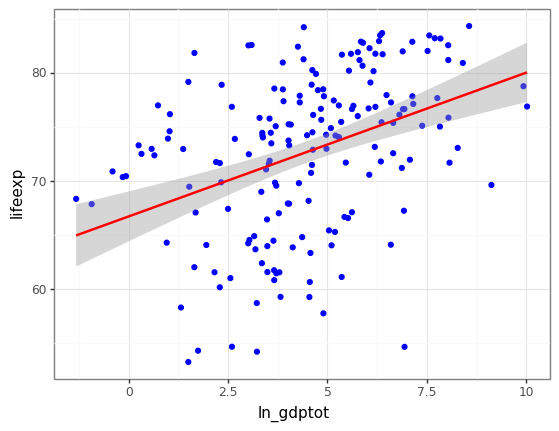

<ggplot: (343000491)>

In [16]:
(
    ggplot(df, aes(x="ln_gdptot", y="lifeexp"))
    + geom_point(color="blue")
    + geom_smooth(method="lm", color="red")
    + theme_bw()
)

In [17]:
reg2 = smf.ols("lifeexp ~ ln_gdptot + ln_gdptot_sq", data=df).fit(cov_type ="HC3")
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     18.35
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           5.73e-08
Time:                        19:19:00   Log-Likelihood:                -598.74
No. Observations:                 180   AIC:                             1203.
Df Residuals:                     177   BIC:                             1213.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       68.2985      1.301     52.479      0.000      65.748      70.849
ln_gdptot        0.3839      0.569      0.674      0.500      -0.732       1.499
ln_gdptot_sq     0.1085      0.066      1.642      0.101      -0.021       0.238
==============================================================================
Omnibus:                        9.652   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.321
Skew:                          -0.575   Prob(JB):                      0.00574
Kurtosis:                       2.768   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

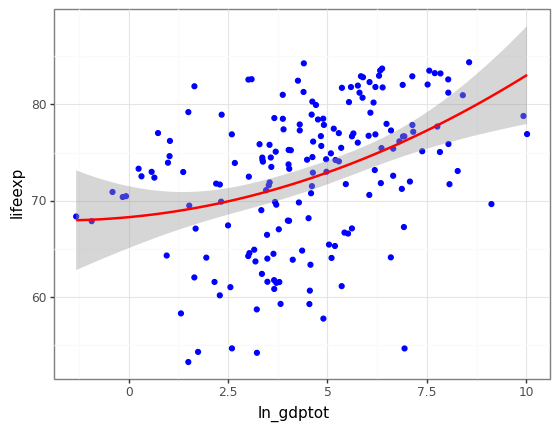

<ggplot: (343041592)>

In [18]:
(
    ggplot(df, aes(x="ln_gdptot", y="lifeexp"))
    + geom_point(color="blue")
    + geom_smooth(method="lm",formula = "y ~ x + np.square(x)", color="red")
    + theme_bw()
)

In [19]:
reg3 = smf.ols("lifeexp ~ ln_gdptot + ln_gdptot_sq + ln_gdptot_cb", data=df).fit(cov_type ="HC3")
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     14.03
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           3.06e-08
Time:                        19:19:00   Log-Likelihood:                -595.78
No. Observations:                 180   AIC:                             1200.
Df Residuals:                     176   BIC:                             1212.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       69.6765      1.585     43.948      0.000      66.569      72.784
ln_gdptot       -2.2581      1.250     -1.806      0.071      -4.708       0.192
ln_gdptot_sq     0.9044      0.323      2.796      0.005       0.270       1.538
ln_gdptot_cb    -0.0610      0.023     -2.641      0.008      -0.106      -0.016
==============================================================================
Omnibus:                        7.991   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.310
Skew:                          -0.525   Prob(JB):                       0.0157
Kurtosis:                       2.922   Cond. No.                         947.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [20]:
reg3 = smf.ols("lifeexp ~ ln_gdptot + ln_gdptot_sq + ln_gdptot_cb", data=df).fit(cov_type ="HC3")
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     14.03
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           3.06e-08
Time:                        19:19:00   Log-Likelihood:                -595.78
No. Observations:                 180   AIC:                             1200.
Df Residuals:                     176   BIC:                             1212.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       69.6765      1.585     43.948      0.000      66.569      72.784
ln_gdptot       -2.2581      1.250     -1.806      0.071      -4.708       0.192
ln_gdptot_sq     0.9044      0.323      2.796      0.005       0.270       1.538
ln_gdptot_cb    -0.0610      0.023     -2.641      0.008      -0.106      -0.016
==============================================================================
Omnibus:                        7.991   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.310
Skew:                          -0.525   Prob(JB):                       0.0157
Kurtosis:                       2.922   Cond. No.                         947.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

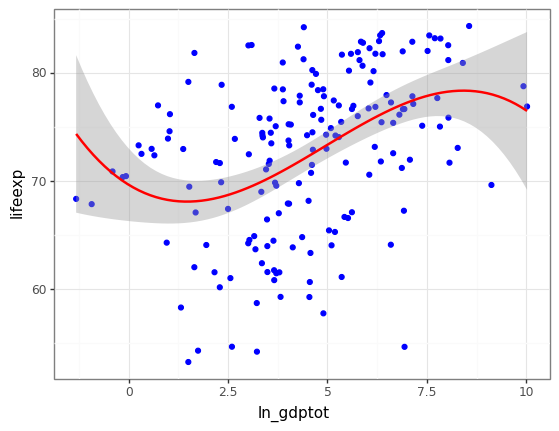

<ggplot: (343149932)>

In [21]:
(
    ggplot(df, aes(x="ln_gdptot", y="lifeexp"))
    + geom_point(color="blue")
    + geom_smooth(method="lm", formula="y ~ x + np.square(x) + np.power(x, 3)", color="red")
    + theme_bw()
)

Compare these models

In [22]:
table = Stargazer([reg1, reg2,reg3])
table

From these you should consider reg1 and reg3 only!

### Models with gdp per capita:
 reg4: lifeexp = alpha + beta * ln_gdppc

In [23]:
reg4 = smf.ols("lifeexp ~ ln_gdppc", data=df).fit(cov_type ="HC3")
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     487.9
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           7.05e-53
Time:                        19:19:00   Log-Likelihood:                -503.28
No. Observations:                 180   AIC:                             1011.
Df Residuals:                     178   BIC:                             1017.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.3901      0.760     78.182      0.000      57.901      60.879
ln_gdppc       5.3492      0.242     22.088      0.000       4.875       5.824
==============================================================================
Omnibus:                       31.573   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.478
Skew:                          -0.976   Prob(JB):                     8.08e-11
Kurtosis:                       4.545   Cond. No.                         7.25
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

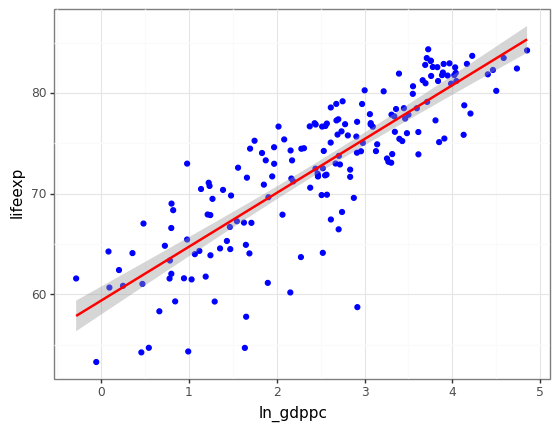

<ggplot: (343192570)>

In [24]:
(
    ggplot(df, aes(x="ln_gdppc", y="lifeexp"))
    + geom_point(color="blue")
    + geom_smooth(method="lm", color="red")
    + theme_bw()
)

In [25]:
reg5 = smf.ols("lifeexp ~ ln_gdppc + ln_gdppc_sq", data=df).fit(cov_type ="HC3")
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     253.9
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           9.89e-53
Time:                        19:19:00   Log-Likelihood:                -503.21
No. Observations:                 180   AIC:                             1012.
Df Residuals:                     177   BIC:                             1022.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      59.0786      1.200     49.228      0.000      56.726      61.431
ln_gdppc        5.7018      1.018      5.603      0.000       3.707       7.696
ln_gdppc_sq    -0.0751      0.197     -0.382      0.703      -0.461       0.310
==============================================================================
Omnibus:                       32.595   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.927
Skew:                          -0.993   Prob(JB):                     2.37e-11
Kurtosis:                       4.606   Cond. No.                         48.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

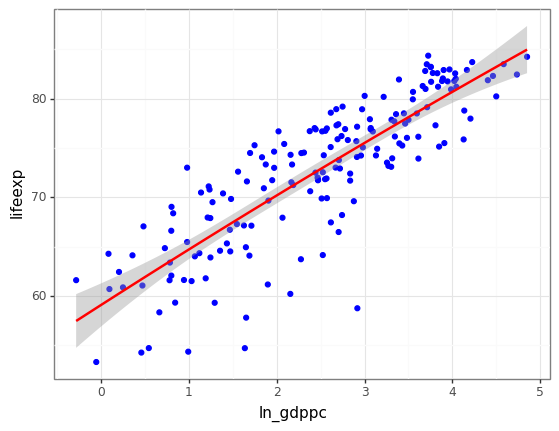

<ggplot: (325629898)>

In [26]:
(
    ggplot(df, aes(x="ln_gdppc", y="lifeexp"))
    + geom_point(color="blue")
    + geom_smooth(method="lm",formula = "y ~ x + np.square(x)",color="red")
    + theme_bw()
)

 Compare results with gdp per capita:

In [27]:
table = Stargazer([reg4, reg5])
table

Conclusion: reg5 is not adding new information

Compare reg1, reg3 and reg4 to get an idea log transformation is a good idea:

In [28]:
table = Stargazer([reg1,reg3,reg4])
table

R2 measure is much better for reg4...

#### Regression with piecewise linear spline:

1st define the cutoff for gdp per capita

In [29]:
cutoff = 50

2nd take care of log transformation -> cutoff needs to be transformed as well

reg6: lifeexp = alpha + beta_1 * ln_gdppc * 1(gdppc < 50) + beta_2 * ln_gdppc * 1(gdppc >= 50)

In [30]:
cutoff_ln = np.log(cutoff)

Note, Python does not have an `lnspline` function as R, so we wrote one

In [31]:
import copy
def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

In [32]:
reg6 = smf.ols("lifeexp ~ lspline(ln_gdppc, cutoff_ln)", data=df).fit(cov_type ="HC3")
reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     287.2
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           2.68e-56
Time:                        19:19:00   Log-Likelihood:                -502.54
No. Observations:                 180   AIC:                             1011.
Df Residuals:                     177   BIC:                             1021.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          59.1218      0.804     73.548      0.000      57.546      60.697
lspline(ln_gdppc, cutoff_ln)[0]     5.4973      0.276     19.916      0.000       4.956       6.038
lspline(ln_gdppc, cutoff_ln)[1]     2.4826      1.161      2.138      0.033       0.207       4.758
==============================================================================
Omnibus:                       33.438   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.179
Skew:                          -1.005   Prob(JB):                     7.70e-12
Kurtosis:                       4.668   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

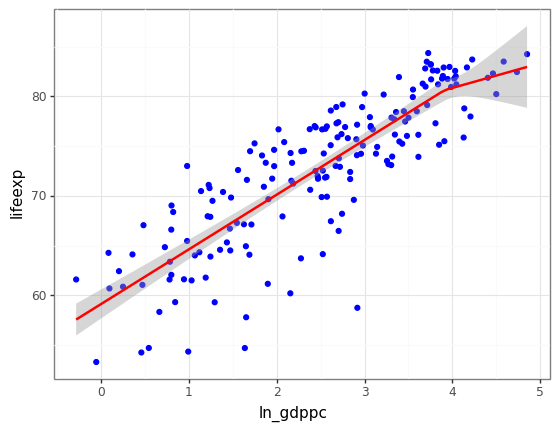

<ggplot: (355020996)>

In [33]:
(
    ggplot(df, aes(x="ln_gdppc", y="lifeexp"))
    + geom_point(color="blue")
    + geom_smooth(method="lm",formula = "y ~ lspline(x,cutoff_ln)",color="red")
    + theme_bw()
)

### Extra
 Weighted-OLS: use reg4 setup and weight with population\
 Can be done with the `weights = df["population"]` input!

In [34]:
reg7 = smf.wls("lifeexp ~ ln_gdppc", weights=df["population"], data=df).fit(cov_type ="HC3")
reg7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.693
Model:                            WLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     80.93
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           3.45e-16
Time:                        19:19:00   Log-Likelihood:                -637.13
No. Observations:                 180   AIC:                             1278.
Df Residuals:                     178   BIC:                             1285.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.8924      1.623     36.295      0.000      55.712      62.073
ln_gdppc       5.7266      0.637      8.996      0.000       4.479       6.974
==============================================================================
Omnibus:                      173.160   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6316.312
Skew:                          -3.322   Prob(JB):                         0.00
Kurtosis:                      31.249   Cond. No.                         8.26
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Created a pretty graph for visualize this method:

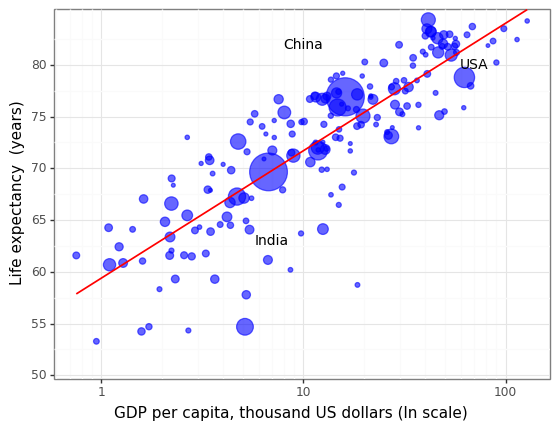

<ggplot: (355069793)>

In [35]:
(
    ggplot(df, aes(x="gdppc", y="lifeexp"))
    + geom_point(df, aes(size="population"), color="blue", alpha=0.6, show_legend=False)
    + geom_smooth(
        aes(weight="population"), method="lm", color="red", se=False, size=0.7
    )
    + scale_size(range=(1, 15))
    + coord_cartesian(ylim=(50, 85))
    + scale_x_log10()
    + scale_y_continuous(expand=(0.01, 0.01), breaks=np.arange(50, 85, 5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
    + annotate("text", x=70, y=80, label="USA", size=10)
    + annotate("text", x=10, y=82, label="China", size=10)
    + annotate("text", x=7, y=63, label="India", size=10)
)

Compare reg4, reg6 and reg7 models

In [36]:
table = Stargazer([reg4, reg6, reg7])
table.custom_columns(["Simple", "L.Spline", "Weighted"], [1, 1, 1])
table

Based on model comparison your chosen model should be reg4 - lifeexp ~ ln_gdppc \

    Substantive: - level-log interpretation works properly for countries
                 - magnitude of coefficients are meaningful
    Statistical: - simple model, easy to interpret
                 - Comparatively high R2 and captures variation well

### Residual analysis

Get the predicted y values from the model

In [37]:
df["reg4_y_pred"] = reg4.fittedvalues

Calculate the errors of the model

In [38]:
df["reg4_res"] = df["lifeexp"] - df["reg4_y_pred"]

Find countries with largest negative errors

In [39]:
worst5 = df.sort_values(by=["reg4_res"]).head(5)
worst5

,country,population,gdppc,lifeexp,gdptot,ln_gdppc,ln_gdptot,ln_gdptot_sq,ln_gdptot_cb,ln_gdppc_sq,reg4_y_pred,reg4_res
63,Equatorial Guinea,1.355982,18.502564,58.735,25.089144,2.917909,3.222435,10.384089,33.462054,8.514195,74.998495,-16.263495
120,Nigeria,200.963603,5.135499,54.687,1032.048476,1.636177,6.939301,48.153897,334.154383,2.677076,68.142289,-13.455289
155,Eswatini,1.148133,8.621804,60.194,9.898978,2.154294,2.292431,5.255242,12.047283,4.640984,70.913787,-10.719787
33,Cote d'Ivoire,25.716554,5.212554,57.783,134.048927,1.651070,4.898205,23.992411,117.519743,2.726032,68.221953,-10.438953
96,Lesotho,2.125267,2.694963,54.331,5.727517,0.991385,1.745282,3.046010,5.316146,0.982843,64.693183,-10.362183


Find countries with largest positive errors

In [40]:
best5 = df.sort_values(by=["reg4_res"]).tail(5)
best5

,country,population,gdppc,lifeexp,gdptot,ln_gdppc,ln_gdptot,ln_gdptot_sq,ln_gdptot_cb,ln_gdppc_sq,reg4_y_pred,reg4_res
141,Rwanda,12.626938,2.227517,69.024,28.126719,0.800888,3.336720,11.133700,37.150040,0.641421,63.674181,5.349819
121,Nicaragua,6.545503,5.451708,74.485,35.684170,1.695929,3.574707,12.778531,45.679508,2.876175,68.461911,6.023089
101,Morocco,36.471766,7.537485,76.680,274.905399,2.019889,5.616427,31.544253,177.165993,4.079950,70.194828,6.485172
68,Honduras,9.746115,5.736182,75.270,55.905486,1.746794,4.023663,16.189860,65.142533,3.051288,68.733996,6.536004
143,Solomon Islands,0.669821,2.660980,72.996,1.782380,0.978694,0.577950,0.334026,0.193050,0.957843,64.625300,8.370700


Show again the scatter plot with bests and worst

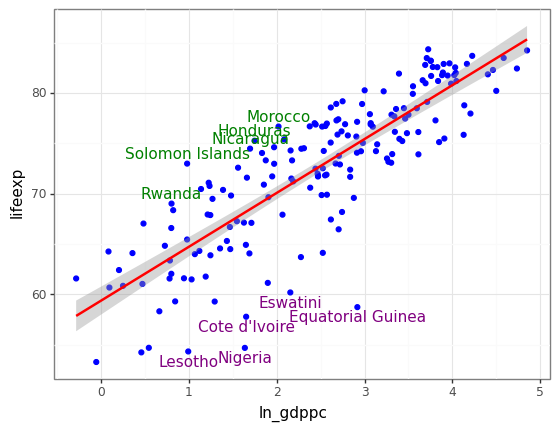

<ggplot: (355130353)>

In [41]:
(
    ggplot(df, aes(x="ln_gdppc", y="lifeexp"))
    + geom_point(color="blue")
    + geom_smooth(method="lm", color="red")
    + annotate(
        "text",
        x=worst5["ln_gdppc"],
        y=worst5["lifeexp"] - 1,
        label=worst5["country"].tolist(),
        color="purple",
    )
    + annotate(
        "text",
        x=best5["ln_gdppc"],
        y=best5["lifeexp"] + 1,
        label=best5["country"].tolist(),
        color="green",
    )
    + theme_bw()
)